In [64]:
import numpy as np
from sklearn.linear_model import Ridge
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd


#Sklearn imports
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

In [3]:
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

# Load data

In [17]:
data_path= '/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files/Richards_2017-10-31.tar'
good_cells, brain_regions,br = get_good_cells(data_path)
#Cub-circuits of interest
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

dat=np.load('trial_av_dat.npy')

#Select two brain regions
mos=dat[brain_regions=='MOs']
scs=dat[brain_regions=='SCs']

#Load behavioral data
beh=np.load('beh.npy')
print(beh.shape)
print(mos.shape)
print(scs.shape)

(260, 75)
(122, 75)
(114, 75)


# Test-train split

In [19]:
#Test-train split
from sklearn.model_selection import train_test_split
#indices=range(75)
front_train, front_test, mid_train,mid_test,beh_train,beh_test=train_test_split(mos.T,scs.T, beh.T,test_size=0.33, random_state=42)
print(beh_train.shape)
print(front_train.shape)

(50, 260)
(50, 122)


# PCA

In [29]:
pca_mid=PCA(n_components=10)
pca_frontal=PCA(n_components=10)
pca_beh=PCA(n_components=10)

pcs_mid=pca_mid.fit_transform(mid_train)
pcs_front=pca_frontal.fit_transform(front_train)
pcs_beh=pca_beh.fit_transform(beh_train)

pcs_mid_test=pca_mid.transform(mid_test)
pcs_front_test=pca_frontal.transform(front_test)
pcs_beh_test=pca_beh.transform(beh_test)

print('Midbrain explained variance by component:',pca_mid.explained_variance_)
print('Frontal brain explained variance by component:',pca_frontal.explained_variance_)
print('Midbrain explained variance cumulative:', np.cumsum(pca_mid.explained_variance_))
print('Frontal brain explained variance cumulative:',np.cumsum(pca_frontal.explained_variance_))
print('Behavior explained variance by component:',pca_beh.explained_variance_)
print('Behavior explained variance cumulative:', np.cumsum(pca_beh.explained_variance_))

print(pcs_beh.shape)
print(pcs_beh_test.shape)

Midbrain explained variance by component: [0.02589523 0.00681757 0.00532994 0.00392899 0.00303052 0.00232405
 0.00207353 0.0019006  0.00142559 0.00125984]
Frontal brain explained variance by component: [0.2255974  0.04749687 0.0053819  0.00257394 0.00129414 0.00120877
 0.00093061 0.00089674 0.00076753 0.00070504]
Midbrain explained variance cumulative: [0.02589523 0.0327128  0.03804275 0.04197174 0.04500226 0.04732631
 0.04939984 0.05130044 0.05272603 0.05398587]
Frontal brain explained variance cumulative: [0.2255974  0.27309427 0.27847617 0.28105011 0.28234425 0.28355302
 0.28448362 0.28538037 0.2861479  0.28685294]
Behavior explained variance by component: [139.32117258  62.03369627  23.5544459   11.26970298   6.5039142
   5.60369889   3.60010615   3.23754519   2.54702362   2.43998061]
Behavior explained variance cumulative: [139.32117258 201.35486885 224.90931475 236.17901773 242.68293193
 248.28663081 251.88673697 255.12428216 257.67130577 260.11128638]
(50, 10)
(25, 10)


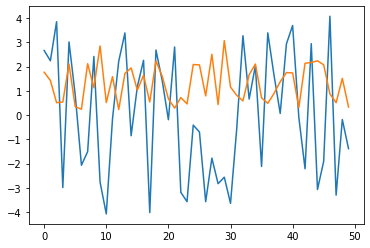

In [26]:
plt.plot(pcs_beh[:,4])
plt.plot(beh_train[:,1])

# Ridge regression to find communication subspace between frontal and midbrain areas

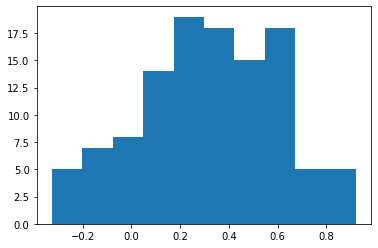

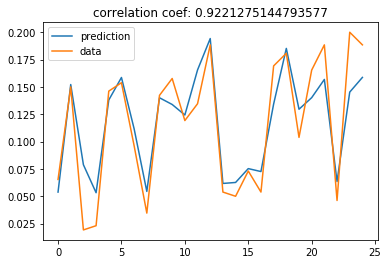

In [69]:
#First do regression on raw counts

def ridge_regression(train_inputs,train_outputs,test_inputs,test_outputs,regularization_parameter=0.01):

    from_front_to_mid_reg=Ridge(regularization_parameter)

    from_front_to_mid_reg.fit(train_inputs,train_outputs)
    prediction=from_front_to_mid_reg.predict(test_inputs)

    pcs_corr=[]
    for j in range(0,test_outputs.shape[1]):
        #print(np.corrcoef(prediction[:,j],test_outputs[:,j])[0,1])
        pcs_corr.append(np.corrcoef(prediction[:,j],test_outputs[:,j])[0,1])

    plt.hist(pcs_corr)
    plt.show()

    ind_to_plot=np.argsort(pcs_corr)[-1]
    #ind_to_plot=2
    plt.plot(prediction[:,ind_to_plot],label='prediction')
    plt.plot(test_outputs[:,ind_to_plot],label='data')
    plt.title('correlation coef: '+str(pcs_corr[ind_to_plot]))
    plt.legend()
    
    return from_front_to_mid_reg
    
from_front_to_mid_reg_all_neurons=ridge_regression(front_train,mid_train,front_test,mid_test)

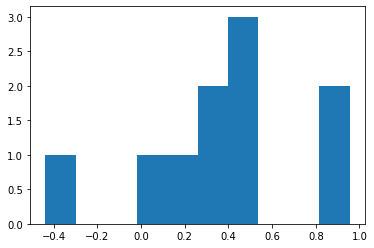

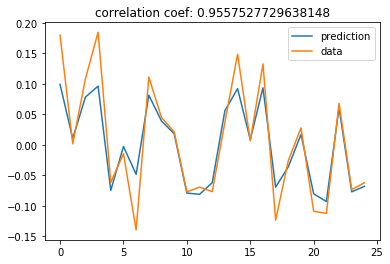

In [70]:
from_front_to_mid_reg=ridge_regression(pcs_front,pcs_mid,pcs_front_test,pcs_mid_test,regularization_parameter=1)


# Extract predictive dimensions using variance explained

In [71]:
def variance_explained_mat(dat_mat,prediction_mat):
    residuals=(dat_mat-prediction_mat.T)**2
    print(residuals.shape)
    natural_variance=(dat_mat-np.mean(dat_mat,axis=0))**2
    print(natural_variance.shape)
    return 1-residuals.sum()/natural_variance.sum()

def variance_explained(dat,prediction):
    residuals=(dat-prediction)**2
    natural_variance=(dat-np.mean(dat))**2
    return 1-residuals.sum()/natural_variance.sum()

In [118]:
# Extract pc dimensions from the PCA transformed frontal activity on test timepoints that predict PC's in the midbrain on test
var_exp=[]
for j in range(0,pcs_mid_test.shape[1]):
    prediction=from_front_to_mid_reg.coef_[j,:]@(pcs_front_test.T)
    var_exp.append(variance_explained(pcs_mid_test[:,j],prediction))

print('Variance explained:', var_exp)
predictive_dimensions=np.where(np.array(var_exp)>0.5)
print('Dimensions that best explain variance on the test set:', predictive_dimensions)
unpredictive_dimensions=np.where(np.array(var_exp)<=0.5)

Variance explained: [0.8406589943802107, 0.8482293513129672, 0.03100799986921099, -0.1404390018360855, 0.2055576412755632, -0.32447473215208267, -0.18837888651911938, -0.16172812855995522, -0.06819416668253786, -0.31936292169868064]
Dimensions that best explain variance on the test set: (array([0, 1]),)


# Ridge regression from frontal subspace to behavior

In [121]:
def ridge_behavior(from_front_to_mid_reg,pcs_front,pcs_front_test,pcs_beh,pcs_beh_test,dimensions):
    ridge_beh=Ridge()
    ridge_beh.fit(pcs_beh,(from_front_to_mid_reg.coef_[dimensions[0],:]@(pcs_front.T)).T)
    pred_beh=ridge_beh.coef_@pcs_beh_test.T
    actual=(from_front_to_mid_reg.coef_@(pca_frontal.transform(front_test).T))[dimensions[0],:]
    for j in range(0,dimensions[0].shape[0]):
        print(j)
        print('corr coef, dim=' + str(dimensions[j])+':', np.corrcoef(pred_beh[j,:],actual[j,:])[0,1])

ridge_behavior(from_front_to_mid_reg,pcs_front,pcs_front_test,pcs_beh,pcs_beh_test,predictive_dimensions)

0
corr coef, dim=[0 1]: 0.995909668210853
1


IndexError: tuple index out of range

# Control using unpredictive dimensions from the frontal cortex

In [120]:
ridge_behavior(from_front_to_mid_reg,pcs_front,pcs_front_test,pcs_beh,pcs_beh_test,unpredictive_dimensions)

0
corr coef, dim=0: 0.9860126148002746
1
corr coef, dim=1: 0.9677067817529698
2
corr coef, dim=2: 0.9875969819475932
3
corr coef, dim=3: 0.9668054627290745
4
corr coef, dim=4: 0.9595929407648616
5
corr coef, dim=5: 0.9746452146055361
6
corr coef, dim=6: 0.9602348734567525
7
corr coef, dim=7: 0.96020414068577
